In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Home Assignment 1 - Regression and Classification Models

#### 0.1. Data Preparation

In [2]:
df = pd.read_csv("HA1-DatasetScaled.tsv", sep="\t")

In [3]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,52.0
1,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,50.0
2,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,41.5
3,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,32.0
4,-2.1737,-1.5994,-0.9850,-1.0041,-0.5006,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,-0.9684,-1.0090,-0.8995,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,29.0


In [4]:
# Check if any column has a missing value overall (not per row)
print(df.isnull().values.any())

False


#### 0.2: Data Splitting

In [5]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('critical_temp', axis=1), df['critical_temp'], test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# X_train, y_train: Training data
# X_test, y_test: Test data
# X_val, y_val: Validation data (IVS)

### **Objective 1** - Produce the best regression model for critical_temp (Dependent Variable)

#### 1.1: Decision trees

We will train the model perform GridSearch on testing set to establish the best hyperparameters `min_sample_leaf` and `max_depth`:

In [6]:
# Combine train and test data for GridSearchCV
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Create an array of indices:
# -1 indicates the sample is part of the training set
# 0 indicates the sample is part of the test set (used for evaluation during GridSearch)
test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_test.shape[0])]
ps = PredefinedSplit(test_fold)

# Define the regressor
dtree_regressor = DecisionTreeRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
    'max_depth': np.arange(2, 7),
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'min_samples_leaf': [5, 10, 20, 25]
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(mean_squared_error, greater_is_better=False)

gridCV = GridSearchCV(dtree_regressor, parameters, scoring=scorer, cv=ps)
gridCV.fit(X_combined, y_combined)
dtree_regressor_best = gridCV.best_estimator_

Let's view the results as a table:

In [7]:
results = gridCV.cv_results_
df_results = pd.DataFrame(results)

# Extract each hyperparameter into its own column from the 'params' column
df_results['max_depth'] = df_results['params'].apply(lambda x: x['max_depth'])
df_results['criterion'] = df_results['params'].apply(lambda x: x['criterion'])
df_results['min_samples_leaf'] = df_results['params'].apply(lambda x: x['min_samples_leaf'])

# Select relevant columns and create the desired dataframe
df_mse = df_results[['max_depth', 'criterion', 'min_samples_leaf', 'mean_test_score']]
df_mse['mean_test_score'] = -df_mse['mean_test_score']  # Convert negative MSE to positive

# Rename columns for clarity
df_mse.columns = ['Max Depth', 'Criterion', 'Min Samples Leaf', 'MSE']

# Drop rows where 'Mean MSE' is NaN
df_mse = df_mse.dropna(subset=['MSE'])

# Display the dataframe
df_mse_sorted = df_mse.sort_values(by='MSE')
df_mse_head = df_mse_sorted.head(5)
print(df_mse_head)


    Max Depth     Criterion  Min Samples Leaf         MSE
36          6  friedman_mse                 5  234.917985
37          6  friedman_mse                10  235.591654
39          6  friedman_mse                25  236.868860
38          6  friedman_mse                20  237.029590
33          5  friedman_mse                10  262.263776


From the results of the GridSearch the best `max_depth` is 6 levels and the best `min_sample_leaf` is 10 samples per leaf. Now let's look at the metrics of the chosen model:

In [8]:
# Predict on the testing set
y_pred_test = dtree_regressor_best.predict(X_test)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print metrics
print(f"Mean Squared Error (MSE) on Testing Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Testing Set: {rmse_test}")
print(f"Mean Absolute Error (MAE) on Testing Set: {mae_test}")
print(f"R-squared on Testing Set: {r2_test}")

Mean Squared Error (MSE) on Testing Set: 218.04258196819833
Root Mean Squared Error (RMSE) on Testing Set: 14.766264997222498
Mean Absolute Error (MAE) on Testing Set: 9.733272914639297
R-squared on Testing Set: 0.8142430436878382


#### 1.2: Linear Models

In [9]:
# 1. LINEAR REGRESSION MODEL #
reg1 = LinearRegression().fit(X_train, y_train)
y_pred1_test = reg1.predict(X_test)

In [10]:
# 2. RIDGE REGRESSION MODEL WITH CROSS-VALIDATION (K-Fold Cross Validation) #

reg2 = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train) # ridge regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1
y_pred2_test = reg2.predict(X_test)
reg2_best_alpha = reg2.alpha_ # Resulting best alpha from cross-validation

In [12]:
# 3. LASSO REGRESSION MODEL WITH CROSS-VALIDATION (K-Fold Cross Validation) #

reg3 = LassoCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], max_iter=10000).fit(X_train, y_train) # lasso regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1
y_pred3_test = reg3.predict(X_test)
reg3_best_alpha = reg3.alpha_ # Resulting best alpha from cross-validation

In [13]:
# 4. LASSO REGRESSION MODEL WITH CROSS-VALIDATION (K-Fold Cross Validation) - With Normalised Features #

# Compute statistics from the training set
mean_train = X_train.mean()
max_min_range_train = X_train.max() - X_train.min()
# Normalize the training set
X_train_norm = (X_train - mean_train) / max_min_range_train
# Normalize the test set using the same statistics from the training set
X_test_norm = (X_test - mean_train) / max_min_range_train

reg4 = LassoCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], max_iter=10000).fit(X_train_norm, y_train) # lasso regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1
y_pred4_test = reg4.predict(X_test_norm)
reg4_best_alpha = reg4.alpha_ # Resulting best alpha from cross-validation

In [14]:
# 5. ELASTIC NET REGRESSION MODEL WiTH CROSS-VALIDATION (K-Fold Cross Validation) #

# Train model
reg5 = ElasticNetCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=10000).fit(X_train, y_train) # elastic net regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1 as well as range of l1_ratio values 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1
y_pred5_test = reg5.predict(X_test)
reg5_best_alpha = reg5.alpha_  # Resulting best alpha from cross-validation
reg5_best_l1_ratio = reg5.l1_ratio_ # Resulting best l1_ratio from cross-validation

*NOTE: The warnings above are the result of models not being able to converge. This is due to the fact that several models with different hyperparameters were tested and for some of the parameters the model did not converge. The models that did not converge were not used in the final model selection.*

#### Linear Models: Results

In [15]:
df_results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2', 'Best Alpha', 'Best l1_ratio'])
# Create data frames for each model
model1 = pd.DataFrame({'Model': 'Linear Regression', 'MSE': mean_squared_error(y_test, y_pred1_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred1_test)), 'MAE': mean_absolute_error(y_test, y_pred1_test), 'R2': r2_score(y_test, y_pred1_test), 'Best Alpha': '-', 'Best l1_ratio': '-'}, index=[0])
model2 = pd.DataFrame({'Model': 'Ridge Regression', 'MSE': mean_squared_error(y_test, y_pred2_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred2_test)), 'MAE': mean_absolute_error(y_test, y_pred2_test), 'R2': r2_score(y_test, y_pred2_test), 'Best Alpha': reg2_best_alpha, 'Best l1_ratio': '-'}, index=[1])
model3 = pd.DataFrame({'Model': 'Lasso Regression', 'MSE': mean_squared_error(y_test, y_pred3_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred3_test)), 'MAE': mean_absolute_error(y_test, y_pred3_test), 'R2': r2_score(y_test, y_pred3_test), 'Best Alpha': reg3_best_alpha, 'Best l1_ratio': '-'}, index=[2])
model4 = pd.DataFrame({'Model': 'Lasso Regression (Normalised)', 'MSE': mean_squared_error(y_test, y_pred4_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred4_test)), 'MAE': mean_absolute_error(y_test, y_pred4_test), 'R2': r2_score(y_test, y_pred4_test), 'Best Alpha': reg4_best_alpha, 'Best l1_ratio': '-'}, index=[3])
model5 = pd.DataFrame({'Model': 'ElasticNet Regression', 'MSE': mean_squared_error(y_test, y_pred5_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred5_test)), 'MAE': mean_absolute_error(y_test, y_pred5_test), 'R2': r2_score(y_test, y_pred5_test), 'Best Alpha': reg5_best_alpha, 'Best l1_ratio': reg5_best_l1_ratio}, index=[4])
# Concatenate the data frames
df_results = pd.concat([df_results, model1, model2, model3, model4, model5], ignore_index=True)
df_results

,Model,MSE,RMSE,MAE,R2,Best Alpha,Best l1_ratio
0,Linear Regression,311.754275,17.656565,13.277266,0.734407,-,-
1,Ridge Regression,311.750602,17.656461,13.277173,0.734410,0.01,-
2,Lasso Regression,311.898822,17.660657,13.274335,0.734284,0.001,-
3,Lasso Regression (Normalised),313.654581,17.710296,13.314416,0.732788,0.001,-
4,ElasticNet Regression,311.898822,17.660657,13.274335,0.734284,0.001,1.0


#### REGRESSION MODEL SELECTION:
The Decision Tree Regression has lower error metrics (MSE, RMSE, and MAE), indicating more accurate predictions, and a higher R-squared (R2), suggesting a better fit to the data, making it a superior model. Therefore, we decided to go with the Decision Tree Regression model. Let's now test the model on independent validation set (IVS):

In [16]:
# Predict on validation set - Decision Tree
y_pred_val = dtree_regressor_best.predict(X_val)
# Define metrics for validation set
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
# Calculate metrics for validation set
metrics_val = {
    "Validation Set": [mse_val, rmse_val, mae_val, r2_val]
}
# Calculate metrics for testing set
metrics_test = {
    "Testing Set": [mse_test, rmse_test, mae_test, r2_test]
}
# Create DataFrames
df_metrics_val = pd.DataFrame(metrics_val, index=["MSE", "RMSE", "MAE", "R-squared"])
df_metrics_test = pd.DataFrame(metrics_test, index=["MSE", "RMSE", "MAE", "R-squared"])
# Combine the DataFrames for validation and testing metrics
df_metrics = pd.concat([df_metrics_val, df_metrics_test], axis=1)
df_metrics

,Validation Set,Testing Set
MSE,228.772711,218.042582
RMSE,15.125234,14.766265
MAE,9.944892,9.733273
R-squared,0.808855,0.814243


***CONCUSION:*** The metrics on the validation set are reasonably close to those on the test set which suggests that our model is performing consistently and is likely to generalize well to new, unseen data.

### **Objective 2** - Produce the best binary classification model assuming as positive all instances with values of critical_temp >= 80.0 and as negatives all remaining cases

Firstly, we need to transform all the target columns to the binary classification problem instances.

In [17]:
# transform the target column to a binary classification problem: 0 - negative, 1 - positive
def transform_to_binary(x):
    return 1 if x >= 80 else 0

y_train_bin = y_train.apply(transform_to_binary)
y_val_bin = y_val.apply(transform_to_binary)
y_test_bin = y_test.apply(transform_to_binary)

In [18]:
y_train_bin.value_counts()

0    11327
1     2224
Name: critical_temp, dtype: int64

We can see that the data is imbalanced, we have much more negative (0) observations. Therefore, we will use `F1 score` as our main metric.

#### 2.1 Decision tree

In [19]:
def get_classification_scores(y_true, y_predicted):
    return pd.DataFrame([
        ['Accuracy', round(accuracy_score(y_true, y_predicted), 4)],
        ['Precision', round(precision_score(y_true, y_predicted), 4)],
        ['Recall', round(recall_score(y_true, y_predicted), 4)],
        ['F1 score', round(f1_score(y_true, y_predicted), 4)]
    ], columns=['metric', 'score'])

def print_confusion_matrix(y_true, y_predicted):
    print("The Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(y_true, y_predicted)))

We will explore different values of the following hyperparameters: `min_samples_leaf`, `max_depth`

In [20]:
min_samples_leaf_values = range(2,50,2)
max_depth_values = range(2,50,2)

results = {"min_samples_leaf": [], "max_depth": [], "F1": []}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        model.fit(X_train, y_train_bin)
        y_preds = model.predict(X_test)
        f1 = f1_score(y_test_bin, y_preds)

        results["min_samples_leaf"].append(min_samples_leaf)
        results["max_depth"].append(max_depth)
        results["F1"].append(f1)

scores_df = pd.DataFrame(results, index=None)
scores_df = scores_df.sort_values(by="F1", ascending=False)

best_max_depth = int(scores_df.iloc[0].max_depth)
best_min_samples_leaf = int(scores_df.iloc[0].min_samples_leaf)

scores_df.head()

,min_samples_leaf,max_depth,F1
456,2,40,0.794275
504,2,44,0.782453
314,6,28,0.780357
408,2,36,0.780142
288,2,26,0.779783


Model with `max_depth`=6 And `min_samples_leaf`=24 turned out to be the best. However, if we look at the table below showing 5 best performing hyperparameters combinations, we can make a few interesting observations. 
The F1 scores for all those models are very similar and `min_samples_leaf`=6 seems to be a very stable value. However, when it comes to `max_depth`, we don’t see one definite value. There is quite a big variation in this value among the models.
Therefore, we decided to investigate `max_depth` value deeper.

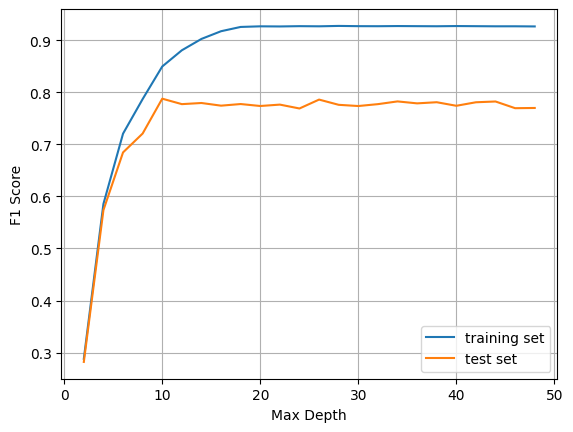

In [21]:
f1_scores_train = []
f1_scores_test = []

for max_depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=best_min_samples_leaf)
    model.fit(X_train, y_train_bin)
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    f1_scores_train.append(f1_score(y_train_bin, y_preds_train))
    f1_scores_test.append(f1_score(y_test_bin, y_preds_test))

plt.plot(max_depth_values, f1_scores_train, label='training set')
plt.plot(max_depth_values, f1_scores_test, label='test set')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

Based on the plot above we can see that the upper bound for the F1 score on the test set stabilizes at approximately 0.78.. We already get almost the best possible results (on the test set) for `max_depth`~18 and increasing `max_depth` does not give us any significant improvements. Thus, we set `max_depth`=18.

Final model

In [22]:
def get_final_model_scores(model, validation_set=False):
    model.fit(X_train, y_train_bin)

    y_preds_test = model.predict(X_test)
    test_set_scores_df = get_classification_scores(y_test_bin, y_preds_test).rename(columns={'score': 'test_set'})

    if validation_set:
        y_preds_val = model.predict(X_val)
        validation_set_scores_df = get_classification_scores(y_val_bin, y_preds_val).rename(columns={'score': 'validation_set'})
        return pd.merge(test_set_scores_df, validation_set_scores_df, on='metric')
    return test_set_scores_df

In [23]:
best_max_depth = 18
decision_tree_model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
get_final_model_scores(decision_tree_model)

,metric,test_set
0,Accuracy,0.9256
1,Precision,0.8108
2,Recall,0.7317
3,F1 score,0.7692


#### 2.2. Linear Models

In [24]:
c_values = [0.001, 0.01, 0.1, 1, 10]
solver_and_penalty = {'lbfgs': ['l2', None], 'liblinear': ['l1', 'l2'], 'newton-cg': ['l2', None],
                      'newton-cholesky': ['l2', None], 'sag': ['l2', None], 'saga': ['l1', 'l2', None]}

results = {"c": [], "solver": [], "penalty": [], "F1": []}

for c in c_values:
    for solver in solver_and_penalty.keys():
        for penalty in solver_and_penalty[solver]:
            model = LogisticRegression(C=c, solver=solver, penalty=penalty)
            model.fit(X_train, y_train_bin)
            y_pred_test = model.predict(X_test)
            f1 = f1_score(y_test_bin, y_pred_test)

            results['c'].append(c)
            results['solver'].append(solver)
            results['penalty'].append(penalty)
            results['F1'].append(f1)

scores_df = pd.DataFrame(results, index=None)
scores_df = scores_df.sort_values(by="F1", ascending=False)

best_c = scores_df.iloc[0].c # any
best_solver = scores_df.iloc[0].solver # newton-cg/newton-cholesky
best_penalty = scores_df.iloc[0].penalty # None

scores_df.head()

,c,solver,penalty,F1
57,10.000,newton-cg,None,0.691137
20,0.010,newton-cholesky,None,0.691137
46,1.000,newton-cholesky,None,0.691137
5,0.001,newton-cg,None,0.691137
7,0.001,newton-cholesky,None,0.691137


Final Model

In [25]:
logistic_regression_model = LogisticRegression(C=best_c, solver=best_solver, penalty=best_penalty)
get_final_model_scores(logistic_regression_model)

,metric,test_set
0,Accuracy,0.8982
1,Precision,0.7109
2,Recall,0.6725
3,F1 score,0.6911


In [26]:
# We picked the Decision Tree model because it achieved better results
get_final_model_scores(decision_tree_model, validation_set=True)

,metric,test_set,validation_set
0,Accuracy,0.9253,0.9280
1,Precision,0.7945,0.8204
2,Recall,0.7544,0.7603
3,F1 score,0.7739,0.7892
